![](https://pm4py.fit.fraunhofer.de/static/assets/images/pm4py-site-logo-padded.png)

# 0. Introduction

**Process:**  
By process we mean a collection of discrete events (activities) in order to achieve a certain goal.

**Process mining:**  
A set of techniques used for obtaining knowledge of and extracting insights from processes by the means of analyzing the event data, generated during the execution of the process. The end goal of process mining is to discover, model, monitor, and optimize the underlying processes.

**Potential benefits of process mining:**
- Process discovery — Converting an event log into a process model.
- Conformance checking — Investigating the differences between the model and what happens in real life. This way the companies can identify deviations from the model and determine their severity/cost.
- Throughput analysis/bottleneck detection — Accounting for the intensity of events’ execution (measured by time spent to complete a particular event) in order to determine potential bottlenecks. This kind of analysis can be used to improve time-related KPIs by minimizing throughput/overhead time.

**Event log:**   
In order to carry out process mining, a dataset must contain (at least) the following 3 types of information:
- Case ID — A unique identifier of an entity going through the process. A common example could be the user’s unique ID, although, many possibilities are valid (it depends on the use case).
- Event — A step of the process, any activity that is a part of the process being analyzed.
- Timestamp — Used for performance evaluation and determining the order of events, can be the time when the user entered/exited the given event (or both actually).

# 1. Setup

## 1.1 Packages

In [1]:
# general
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pm4py

# data
from pm4py.objects.log.util import dataframe_utils
from pm4py.objects.log.exporter.xes import exporter as xes_exporter
from pm4py.objects.log.importer.xes import importer as xes_importer

# process mining
from pm4py.algo.discovery.alpha import algorithm as alpha_miner
from pm4py.algo.discovery.inductive import algorithm as inductive_miner
from pm4py.algo.discovery.heuristics import algorithm as heuristics_miner
from pm4py.algo.discovery.dfg import algorithm as dfg_discovery

# viz
from pm4py.visualization.petrinet import visualizer as pn_visualizer
from pm4py.visualization.process_tree import visualizer as pt_visualizer
from pm4py.visualization.heuristics_net import visualizer as hn_visualizer
from pm4py.visualization.dfg import visualizer as dfg_visualization

# misc
from pm4py.objects.conversion.process_tree import converter as pt_converter

#from pm4py.objects.petri import semantics
#from pm4py.algo.conformance.tokenreplay import algorithm as token_replay
#from pm4py.objects.conversion.process_tree import converter as pt_converter
#from pm4py.objects.petri import semantics

## 1.2 Environment

In [2]:
print(f'platform     {sys.platform}')
print(f'environment  {sys.prefix}')
print(f'python       {sys.version_info.major}.{sys.version_info.minor}.{sys.version_info.micro}')

platform     linux
environment  /home/rene/miniconda3/envs/processmining
python       3.8.5


## 1.3 Versions

In [79]:
pd.DataFrame(
    [
        ['pandas', f'{pd.__version__}'], 
        ['numpy ', f'{np.__version__}'], 
        ['matplotlib', f'{sys.modules["matplotlib"].__version__}'], 
        ['pm4py', f'{pm4py.__version__}']
    ], 
    columns = ['package', 'version']
).set_index('package')

,version
package,
pandas,1.2.0
numpy,1.19.2
matplotlib,3.3.2
pm4py,2.1.3.2


## 1.4 Directories

In [4]:
directories = ['log', 'output']

In [5]:
for directory in directories:
    if not os.path.isdir(directory):
        os.mkdir(directory)

## 1.5 Display

In [6]:
pd.set_option('display.max_rows', 50)

## 1.6 Functions

In [7]:
def edge_matrix(event_log: pd.DataFrame, case_var: str, event_var: str, timestamp_var: str) -> pd.DataFrame:
    """
    Return a matrix based on the traces in the event log.
    Events in the index are events 'from' and events in the columns are events 'to'.
    So the matrix contains all edge frequencies.
    """
    
    # event log
    log = event_log[[case_var, event_var, timestamp_var]]
    
    # initiate footprint matrix
    events = log[event_var].unique()
    matrix = pd.DataFrame(columns=events, index=events).fillna(0)
    
    # groupby case_var
    groups = log.groupby(case_var)
    
    # loop through case groups
    for group in groups:
        event = group[1].sort_values(timestamp_var)\
        .drop([case_var, timestamp_var], axis = 1)\
        .rename(columns = {event_var:'event_from'})
        event['event_to'] = event['event_from'].shift(-1)
        event.dropna(inplace = True)
        
        # loop through traces
        for trace in event.itertuples(index = False):
            matrix.at[trace.event_from, trace.event_to] += 1
    
    return matrix

In [95]:
def edge_frequency(edge_matrix: pd.DataFrame) -> pd.DataFrame:
    """
    Returns an egde list with frequencies in the form of a pandas DataFrame
    """
    
    edges = list()
    
    for row in edge_matrix.index:
        for col in edge_matrix.columns:
            if edge_matrix.at[row, col] != 0:
                edges.append((row, col, edge_matrix.at[row, col]))
    
    edge_freq = pd.DataFrame(edges, columns = ['event_from', 'event_to', 'frequency'])\
    .set_index(['event_from', 'event_to'])
    
    return edge_freq

In [315]:
def edge_duration(event_log: pd.DataFrame, case_var: str, event_var: str, timestamp_var: str, duration: str ='h') -> pd.DataFrame:
    """
    Returns an egde list with durations.
    By default duration is set to hours (h). Use 'D' for days and 'W' for weeks.
    """
    
    data = dict()
    groups = log_csv.groupby(case_var)
    for group in groups:
        edge = group[1].sort_values(timestamp_var).rename(columns = {event_var:'event_from', timestamp_var:'time_from'})
        edge['event_to'] = edge['event_from'].shift(-1)
        edge['time_to'] = edge['time_from'].shift(-1)
        edge.dropna(inplace = True)
        duration_var = f'duration ({duration})'
        edge[duration_var] = (edge['time_to'] - edge['time_from']) / np.timedelta64(1, duration)
        data[group[0]] = edge[[case_var, 'event_from', 'event_to', 'time_from', 'time_to', duration_var]]
    return pd.concat(data.values()).set_index(case_var)

# 2. Data Prepatation

## 2.1 Read Data

In [316]:
log_csv = pd.read_csv('data/running-example.csv', sep=';')

## 2.2 Convert Data

In [317]:
log_csv = dataframe_utils.convert_timestamp_columns_in_df(log_csv)

## 2.3 Explore Data

In [318]:
# Shape
log_csv.shape

(42, 5)

In [319]:
# Check NA-values
log_csv.isna().sum()

case_id      0
activity     0
timestamp    0
costs        0
resource     0
dtype: int64

In [320]:
# Info
log_csv.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   case_id    42 non-null     int64              
 1   activity   42 non-null     object             
 2   timestamp  42 non-null     datetime64[ns, UTC]
 3   costs      42 non-null     int64              
 4   resource   42 non-null     object             
dtypes: datetime64[ns, UTC](1), int64(2), object(2)
memory usage: 1.8+ KB


In [321]:
# Sample
log_csv.sample(n=7)

,case_id,activity,timestamp,costs,resource
13,2,pay compensation,2011-01-08 11:05:00+00:00,200,Ellen
19,6,register request,2011-01-06 14:02:00+00:00,50,Mike
39,4,examine thoroughly,2011-01-08 13:43:00+00:00,400,Sean
33,5,examine casually,2011-01-21 08:06:00+00:00,400,Sue
5,3,examine thoroughly,2011-01-06 12:06:00+00:00,400,Sean
11,2,examine casually,2010-12-30 13:16:00+00:00,400,Sean
16,1,check ticket,2011-01-05 14:12:00+00:00,100,Mike


In [322]:
# Sample data
log_csv.sample(n=7)

,case_id,activity,timestamp,costs,resource
7,3,decide,2011-01-09 08:55:00+00:00,200,Sara
22,6,decide,2011-01-07 15:52:00+00:00,200,Sara
0,3,register request,2010-12-30 13:32:00+00:00,50,Pete
33,5,examine casually,2011-01-21 08:06:00+00:00,400,Sue
37,4,register request,2011-01-06 14:02:00+00:00,50,Pete
36,5,reject request,2011-01-24 13:56:00+00:00,200,Mike
19,6,register request,2011-01-06 14:02:00+00:00,50,Mike


In [323]:
# Unique values
pd.DataFrame(
    {
        'variable': log_csv.columns, 
        'unique values': [log_csv[col].nunique() for col in log_csv.columns],
        'fraction': [round(log_csv[col].nunique() / log_csv.shape[0], 2) for col in log_csv.columns], 
    }
).set_index('variable')

,unique values,fraction
variable,,
case_id,6,0.14
activity,8,0.19
timestamp,41,0.98
costs,4,0.10
resource,6,0.14


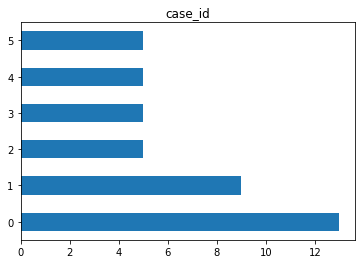

In [324]:
# Value counts: case_id
log_csv.case_id.value_counts().reset_index(drop=True).plot(y='case_id', kind='barh', title='case_id')
plt.show()

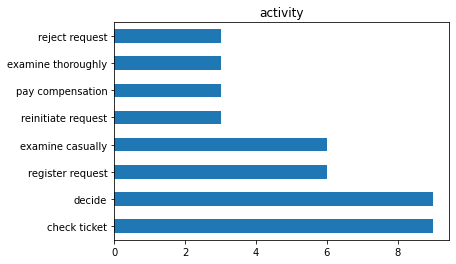

In [325]:
# Value counts: activity
log_csv.activity.value_counts().plot(y='activity', kind='barh', title='activity')
plt.show()

In [326]:
# Unique values: timestamp
log_csv.timestamp.nunique()

41

In [327]:
# Multiple occurences: timestamp
log_csv.timestamp.value_counts()[log_csv.timestamp.value_counts() > 1]

2011-01-06 14:02:00+00:00    2
Name: timestamp, dtype: int64

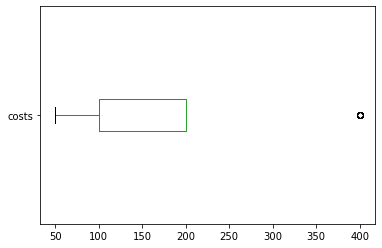

In [328]:
# Value distrubution: costs
log_csv.costs.plot(kind='box', vert=False)
plt.show()

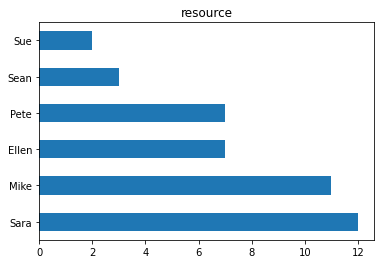

In [329]:
# Value counts: resource
log_csv.resource.value_counts().plot(y='resource', kind='barh', title='resource')
plt.show()

In [330]:
# Sort data
log_csv.sort_values(['case_id', 'timestamp'])

,case_id,activity,timestamp,costs,resource
14,1,register request,2010-12-30 10:02:00+00:00,50,Pete
15,1,examine thoroughly,2010-12-31 09:06:00+00:00,400,Sue
16,1,check ticket,2011-01-05 14:12:00+00:00,100,Mike
17,1,decide,2011-01-06 10:18:00+00:00,200,Sara
18,1,reject request,2011-01-07 13:24:00+00:00,200,Pete
9,2,register request,2010-12-30 10:32:00+00:00,50,Mike
10,2,check ticket,2010-12-30 11:12:00+00:00,100,Mike
11,2,examine casually,2010-12-30 13:16:00+00:00,400,Sean
12,2,decide,2011-01-05 10:22:00+00:00,200,Sara
13,2,pay compensation,2011-01-08 11:05:00+00:00,200,Ellen


In [331]:
# Edge matrix
edge_matrix(log_csv, 'case_id', 'activity', 'timestamp')

,register request,examine casually,check ticket,decide,reinitiate request,examine thoroughly,pay compensation,reject request
register request,0,3,2,0,0,1,0,0
examine casually,0,0,4,2,0,0,0,0
check ticket,0,2,0,6,0,1,0,0
decide,0,0,0,0,3,0,3,3
reinitiate request,0,1,1,0,0,1,0,0
examine thoroughly,0,0,2,1,0,0,0,0
pay compensation,0,0,0,0,0,0,0,0
reject request,0,0,0,0,0,0,0,0


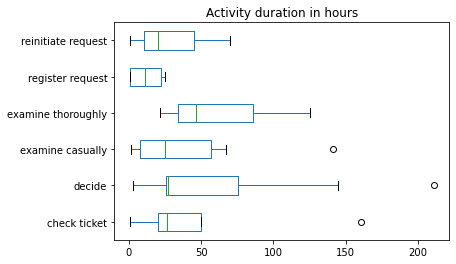

In [332]:
# Boxplot activity duration
event_duration(log_csv, 'case_id', 'activity', 'timestamp')\
.loc[:, ['event_from', 'event_to', 'duration (h)']]\
.reset_index()\
.pivot(columns='event_from', values='duration (h)')\
.plot(kind='box', vert=False, title='Activity duration in hours')
plt.show()

In [458]:
# Edge frequency and (average) duration in hours
df = pd.merge(
    edge_frequency(edge_matrix(log_csv, 'case_id', 'activity', 'timestamp')).reset_index(),
    event_duration(log_csv, 'case_id', 'activity', 'timestamp')\
    .loc[:, ['event_from', 'event_to', 'duration (h)']]\
    .groupby(by = ['event_from', 'event_to']).mean('duration (h)')\
    .reset_index(),
    left_on = ['event_from', 'event_to'],
    right_on = ['event_from', 'event_to']
)

df['duration (h)'] = df['duration (h)'].apply(lambda x: np.round(x, decimals=2))

df

,event_from,event_to,frequency,duration (h)
0,register request,examine casually,3,8.96
1,register request,check ticket,2,10.87
2,register request,examine thoroughly,1,23.07
3,examine casually,check ticket,4,13.32
4,examine casually,decide,2,104.28
5,check ticket,examine casually,2,25.68
6,check ticket,decide,6,50.54
7,check ticket,examine thoroughly,1,26.62
8,decide,reinitiate request,3,18.44
9,decide,pay compensation,3,142.82


# 3. Event Log

## 3.1 Create Event Log

In [334]:
event_log = pm4py.format_dataframe(
    log_csv,
    case_id = 'case_id',
    activity_key = 'activity',
    timestamp_key = 'timestamp'
)

## 3.2 View Event Log

In [335]:
event_log.head()

,case:concept:name,concept:name,time:timestamp,costs,resource,@@index
14,1,register request,2010-12-30 10:02:00+00:00,50,Pete,14
15,1,examine thoroughly,2010-12-31 09:06:00+00:00,400,Sue,15
16,1,check ticket,2011-01-05 14:12:00+00:00,100,Mike,16
17,1,decide,2011-01-06 10:18:00+00:00,200,Sara,17
18,1,reject request,2011-01-07 13:24:00+00:00,200,Pete,18


In [336]:
start_activities = pm4py.get_start_activities(event_log)
end_activities = pm4py.get_end_activities(event_log)

In [337]:
print(f'Start activities: {start_activities}')
print(f'End activities  : {end_activities}')

Start activities: {'register request': 6}
End activities  : {'reject request': 3, 'pay compensation': 3}


## 3.3. Export Event Log (to XES)

In [338]:
xes_exporter.apply(event_log, 'log/running-example.xes')

exporting log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

## 3.4. Import Event Log (from XES)

In [339]:
log = xes_importer.apply('log/running-example.xes')

parsing log, completed traces ::   0%|          | 0/6 [00:00<?, ?it/s]

## 3.5 Event Log

In [340]:
log # log_csv

[{'attributes': {'concept:name': '1'}, 'events': [{'concept:name': 'register request', 'time:timestamp': datetime.datetime(2010, 12, 30, 10, 2, tzinfo=datetime.timezone.utc), 'costs': 50, 'resource': 'Pete', '@@index': 14}, '..', {'concept:name': 'reject request', 'time:timestamp': datetime.datetime(2011, 1, 7, 13, 24, tzinfo=datetime.timezone.utc), 'costs': 200, 'resource': 'Pete', '@@index': 18}]}, '....', {'attributes': {'concept:name': '6'}, 'events': [{'concept:name': 'register request', 'time:timestamp': datetime.datetime(2011, 1, 6, 14, 2, tzinfo=datetime.timezone.utc), 'costs': 50, 'resource': 'Mike', '@@index': 19}, '..', {'concept:name': 'pay compensation', 'time:timestamp': datetime.datetime(2011, 1, 16, 10, 47, tzinfo=datetime.timezone.utc), 'costs': 200, 'resource': 'Mike', '@@index': 23}]}]

In [341]:
len(log) # len(set(log_csv.case_id))

6

In [342]:
log[2] # log_csv[log_csv.case_id == 3]

{'attributes': {'concept:name': '3'}, 'events': [{'concept:name': 'register request', 'time:timestamp': datetime.datetime(2010, 12, 30, 13, 32, tzinfo=datetime.timezone.utc), 'costs': 50, 'resource': 'Pete', '@@index': 0}, '..', {'concept:name': 'pay compensation', 'time:timestamp': datetime.datetime(2011, 1, 15, 9, 45, tzinfo=datetime.timezone.utc), 'costs': 200, 'resource': 'Ellen', '@@index': 8}]}

In [343]:
len(log[2]) # log_csv[log_csv.case_id == 3].shape[0]

9

In [344]:
log[2][-1] # log_csv[log_csv.case_id == 3].tail(1)

{'concept:name': 'pay compensation', 'time:timestamp': datetime.datetime(2011, 1, 15, 9, 45, tzinfo=datetime.timezone.utc), 'costs': 200, 'resource': 'Ellen', '@@index': 8}

# 4. Process Dicovery

## 4.1 Alpha Miner

The alpha miner is one of the most known Process Discovery algorithm and is able to find:

- A [Petri net](https://en.wikipedia.org/wiki/Petri_net) model where all the transitions are visible and unique and correspond to classified events (for example, to activities).
- An initial marking that describes the status of the Petri net model when a execution starts.
- A final marking that describes the status of the Petri net model when a execution ends.

### 4.1.1 Miner

In [345]:
# Miner
net, initial_marking, final_marking = alpha_miner.apply(log)

### 4.1.2 Petri net

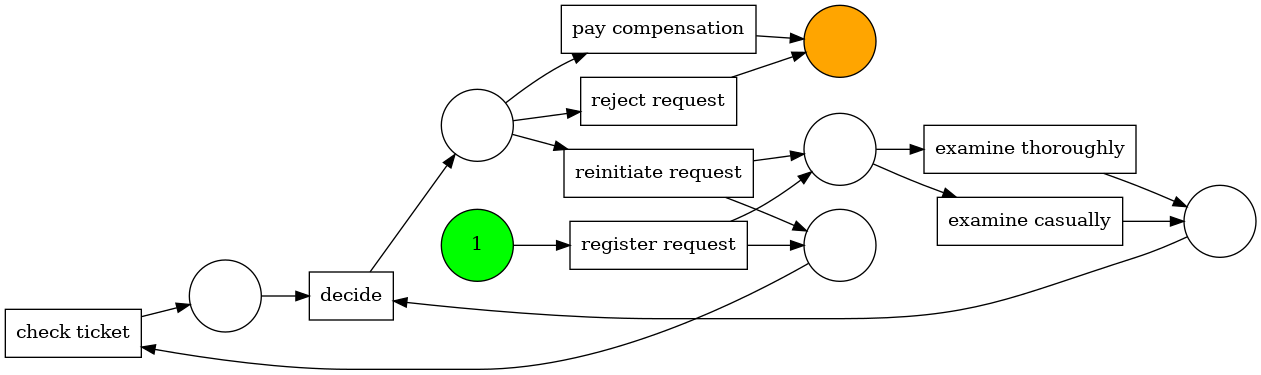

In [346]:
# GraphViz
gviz = pn_visualizer.apply(net, initial_marking, final_marking)

# Save
pn_visualizer.save(gviz, 'output/alpha_miner_pn.png')

# View
pn_visualizer.view(gviz)

#### Trying to understanding the model ....

In [570]:
start_activities_csv = list()
end_activities_csv = list()

for group in log_csv.sort_values('timestamp').groupby('case_id'):
    start_activities_csv.append(group[1].iloc[0, 1])
    end_activities_csv.append(group[1].iloc[-1, 1])

print('Start activities: ', set(start_activities_csv))
print('End activities  : ', set(end_activities_csv))

Start activities:  {'register request'}
End activities  :  {'pay compensation', 'reject request'}


#### Assertions

In [565]:
# assert number of transitions
assert log_csv.activity.nunique() == len(net.transitions)

# assert transition names
assert set(log_csv.activity) == set(str(transition) for transition in net.transitions)

# assert start and end activities
start_activities_csv = list()
end_activities_csv = list()

for group in log_csv.sort_values('timestamp').groupby('case_id'):
    start_activities_csv.append(group[1].iloc[0, 1])
    end_activities_csv.append(group[1].iloc[-1, 1])

start_activities_net = list()
for arc in list(net.arcs):
    if str(arc.source) == 'start': start_activities_net.append(str(arc).split('(t)')[-1])

end_activities_net = list()
for arc in list(net.arcs):
    if str(arc.target) == 'end': end_activities_net.append(str(arc).split('->')[0].replace('(t)', ''))

assert set(start_activities_csv) == set(start_activities_net)
assert set(end_activities_csv) == set(end_activities_net)

#### Questions

No questions!

### 4.1.3 Petri net with frequency information

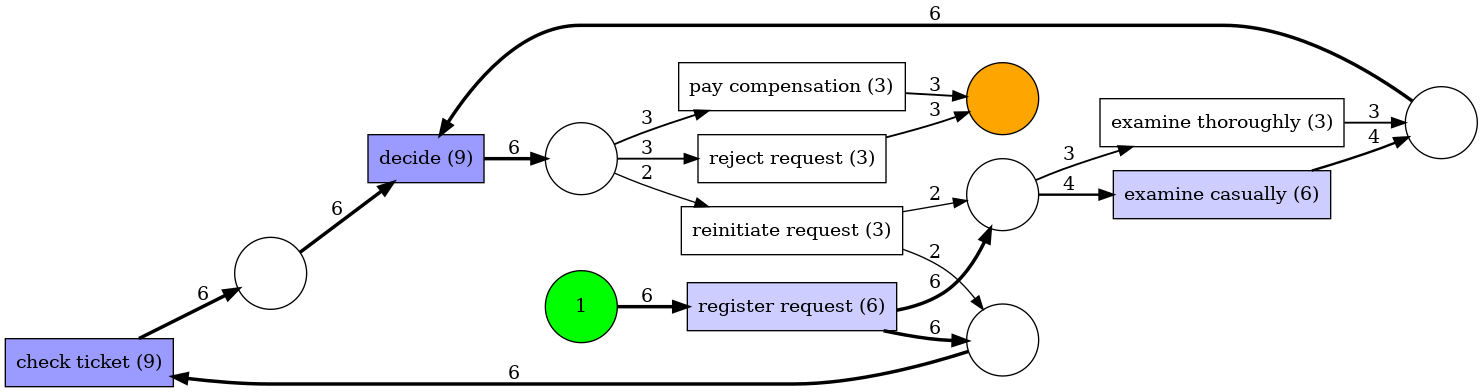

In [347]:
# Parameters
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: 'png'} # svg

# GraphViz
gviz = pn_visualizer.apply(
    net, initial_marking, final_marking,
    parameters=parameters, 
    variant=pn_visualizer.Variants.FREQUENCY, 
    log=log
)

# Save
pn_visualizer.save(gviz, 'output/alpha_miner_pn_frequency.png') # .svg

# View
pn_visualizer.view(gviz)

#### Trying to understanding the model ....

- Unique values and value counts for the variable `activity` in DataFrame `log_csv` are displayed in the rectangles in the model. See `log_csv.activity.unique()` and `log_csv.activity.value_counts()` for unique values and value counts.
- Activities are called transitions in the model. The model has 8 transitions. See `net.transitions`.
- There are no direct connections between transitions (i.e. between the rectangles in the model). Transitions are connected via places and are represented by the circles in the model. The model has 7 places. See `net.places`.

#### Assertions

In [348]:
# assert number of transitions
assert log_csv.activity.nunique() == len(net.transitions)

# assert transition names
assert set(log_csv.activity) == set(str(transition) for transition in net.transitions)

#### Questions

1. The edge count for 'check ticket --> decide' in the model is 6. That is equal to my own counts in table 1. The same applies for 'decide --> pay compensation' and 'decide --> 'reject request'. However, 'decide --> reinitiate request' has a count of 2 in the model and 3 in table 1. Not clear how the frequencies around the places are calculated in the model. From transition 'decide (9)' in the model there is a count of 6 to a point. And from that point there are arc counts 3, 3 and 2. So 6 in and 8 out? Any suggestion how to explain the model and translate it to 'reality' (what lessons can be learned from the model and the counts) and to the input data.

In [349]:
# Table 1: Egde frequencies (from log_csv)
edge_frequency(edge_matrix(log_csv, 'case_id', 'activity', 'timestamp')).reset_index()

,event_from,event_to,frequency
0,register request,examine casually,3
1,register request,check ticket,2
2,register request,examine thoroughly,1
3,examine casually,check ticket,4
4,examine casually,decide,2
5,check ticket,examine casually,2
6,check ticket,decide,6
7,check ticket,examine thoroughly,1
8,decide,reinitiate request,3
9,decide,pay compensation,3


## 5.2 Directly-Follows Graph

Directly-Follows graphs are graphs where the nodes represent the events/activities in the log and directed edges are present between nodes if there is at least a trace in the log where the source event/activity is followed by the target event/activity. On top of these directed edges, it is easy to represent metrics like frequency (counting the number of times the source event/activity is followed by the target event/activity) and performance (some aggregation, for example, the mean, of time inter-lapsed between the two events/activities).

### 5.2.1 Directly-Follows Graph (frequency)

In [350]:
# Miner
dfg = dfg_discovery.apply(log)

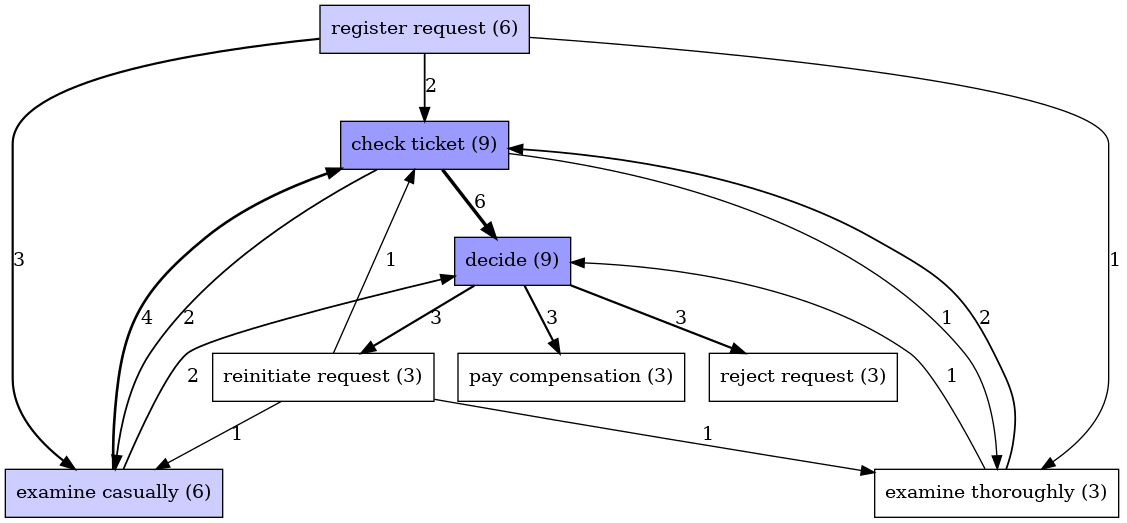

In [351]:
# GraphViz
gviz = dfg_visualization.apply(
    dfg,
    log = log,
    variant = dfg_visualization.Variants.FREQUENCY
)

# Save
dfg_visualization.save(gviz, 'output/dfg_frequency.png')

# View
dfg_visualization.view(gviz)

#### Trying to understanding the model ....

- Unique values and value counts for the variable `activity` in DataFrame `log_csv` are displayed in the rectangles in the model. See `log_csv.activity.unique()` and `log_csv.activity.value_counts()` for unique values and value counts.
- Activities are called transitions in the model. The model has 8 transitions. See `net.transitions`.
- There are no direct connections between transitions (i.e. between the rectangles in the model). Transitions are connected via places and are represented by the circles in the model. The model has 7 places. See `net.places`.

#### Assertions

In [352]:
# assert number of transitions
assert log_csv.activity.nunique() == len(set([key[0] for key in dfg.keys()]\
                                             + [key[1] for key in dfg.keys()]))

# assert transition names
assert set(log_csv.activity) == set([key[0] for key in dfg.keys()] + [key[1] for key in dfg.keys()])

# asset transition frequencies
# no information available in 'dfg', however frequencies in the (visual) model resemble value counts on 'ĺog_csv'
# --> log_csv.activity.value_counts()

# assert edge frequencies
assert set(((row.event_from, row.event_to), row.frequency) for row in\
          edge_frequency(edge_matrix(log_csv, 'case_id', 'activity', 'timestamp'))\
          .reset_index().itertuples(index=False)) == set(dfg.items())

In [353]:
# transition frequencies
log_csv.activity.value_counts()

check ticket          9
decide                9
register request      6
examine casually      6
reinitiate request    3
pay compensation      3
examine thoroughly    3
reject request        3
Name: activity, dtype: int64

#### Questions

No questions! Directly-Follows Graph perfectly reproducible from the `log_csv'.

### 5.2.2 Directly-Follows Graph (performance)

Decorate the edges by using the performance metrics. By using the PERFORMANCE variant the average time elapsed between two nodes will be displayed.

In [354]:
# Miner
dfg = dfg_discovery.apply(log, variant=dfg_discovery.Variants.PERFORMANCE)

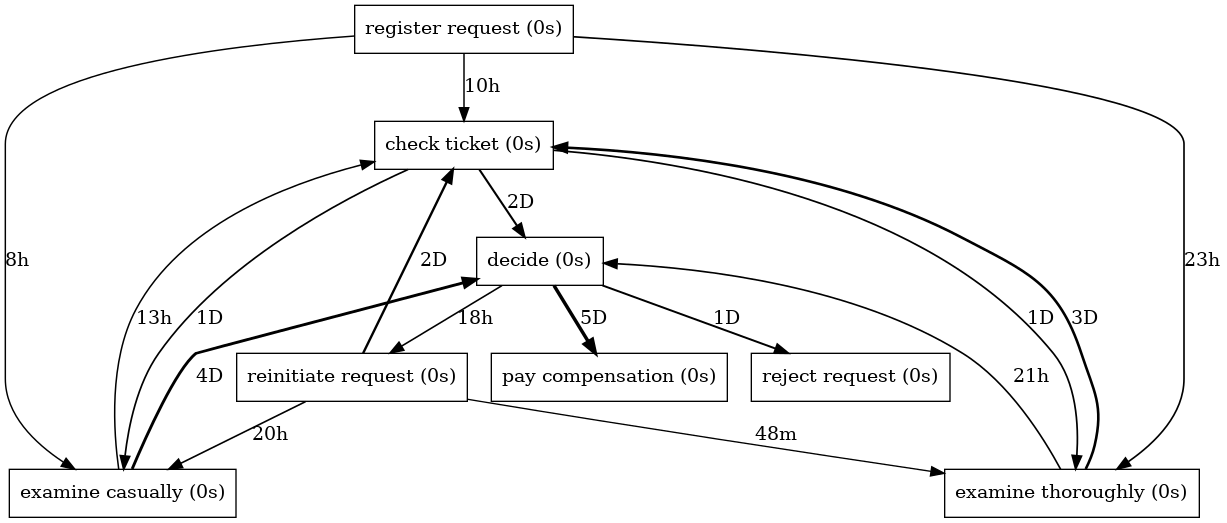

In [355]:
# GraphViz
gviz = dfg_visualization.apply(
    dfg,
    log = log,
    variant = dfg_visualization.Variants.PERFORMANCE
)

# Save
dfg_visualization.save(gviz, 'output/dfg_performance.png')

# View
dfg_visualization.view(gviz)

#### Trying to understanding the model ....

In [408]:
# Duration in days
duration_D = event_duration(log_csv, 'case_id', 'activity', 'timestamp', duration='D')\
.groupby(by = ['event_from', 'event_to']).mean('duration (D)')\
.reset_index()
duration_D['duration (D)'] = np.floor(duration_D['duration (D)']).astype(int)

# Duration in hours
duration_h = event_duration(log_csv, 'case_id', 'activity', 'timestamp', duration='h')\
.groupby(by = ['event_from', 'event_to']).mean('duration (h)')\
.reset_index()
duration_h['duration (h)'] = np.floor(duration_h['duration (h)']).astype(int)

# Duration in minutes
duration_m = event_duration(log_csv, 'case_id', 'activity', 'timestamp', duration='m')\
.groupby(by = ['event_from', 'event_to']).mean('duration (m)')\
.reset_index()
duration_m['duration (m)'] = np.floor(duration_m['duration (m)']).astype(int)

# Merge durations
Dhm = pd.merge(
    pd.merge(duration_D,
             duration_h,
             on=['event_from', 'event_to']
            ),
    duration_m,
    on=['event_from', 'event_to']
)

# Select durations
duration = list()
for row in Dhm.itertuples(index=False):
    if row._2 >= 1:
        duration.append(f'{row._2}D')
    elif row._3 >= 1:
        duration.append(f'{row._3}h')
    else:
        duration.append(f'{row._4}m')
Dhm['duration'] = duration

# View durations
Dhm[['event_from', 'event_to', 'duration']]

,event_from,event_to,duration
0,check ticket,decide,2D
1,check ticket,examine casually,1D
2,check ticket,examine thoroughly,1D
3,decide,pay compensation,5D
4,decide,reinitiate request,18h
5,decide,reject request,1D
6,examine casually,check ticket,13h
7,examine casually,decide,4D
8,examine thoroughly,check ticket,3D
9,examine thoroughly,decide,21h


#### Assertions

In [439]:
# Duration in seconds
duration_s = event_duration(log_csv, 'case_id', 'activity', 'timestamp', duration='s')\
.groupby(by = ['event_from', 'event_to']).mean('duration (s)')\
.reset_index()

# Dataframe to dictonary
duration_s_dict = dict()
for row in duration_s.itertuples(index=False):
    duration_s_dict[(row.event_from, row.event_to)] = int(row._2)

# Assert duration (in seconds)
assert duration_s_dict.items() == dfg.items()

#### Questions

No questions! Directly-Follows Graph performance perfectly reproducible from the `log_csv'.

## 5.3 Heuristic Miner

Heuristics Miner is an algorithm that acts on the Directly-Follows Graph, providing way to handle with noise and to find common constructs (dependency between two activities, AND). The output of the Heuristics Miner is an Heuristics Net, so an object that contains the activities and the relationships between them.

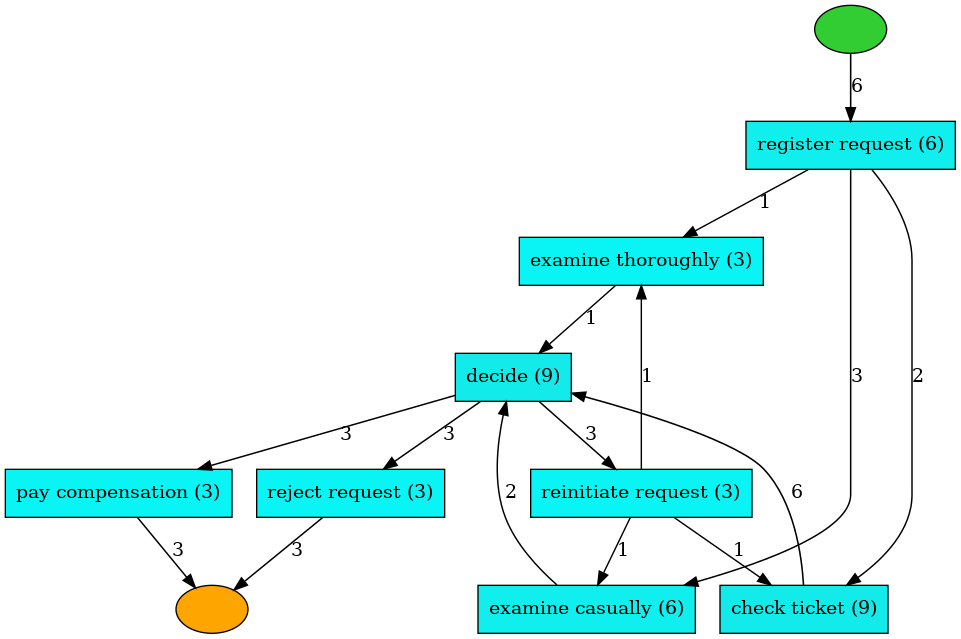

In [460]:
# Miner
heu_net = heuristics_miner.apply_heu(log)

# GraphViz
gviz = hn_visualizer.apply(heu_net)

# View
hn_visualizer.view(gviz)

#### Trying to understanding the model ....

In [495]:
heu_net.start_activities

[{'register request': 6}]

In [496]:
heu_net.end_activities

[{'reject request': 3, 'pay compensation': 3}]

#### Assertions

In [497]:
# assert activities
set(log_csv.activity.unique()) == set(heu_net.activities)

# assert activity frequencies
assert log_csv.activity.value_counts().to_dict() == heu_net.activities_occurrences

# assert edge frequencies
assert dict(set(((row.event_from, row.event_to), row.frequency) for row in\
                edge_frequency(edge_matrix(log_csv, 'case_id', 'activity', 'timestamp'))\
                .reset_index().itertuples(index=False))) == heu_net.dfg

#### Questions

No questions! Heuristic Minder perfectly reproducible from the `log_csv'.

## To Do List

Convert the Heuristics Net into a Petri net. The generated model is much more complex than the one generated by the Alpha Miner.

In [52]:
# Miner
net, initial_marking, final_marking = heuristics_miner.apply(log)

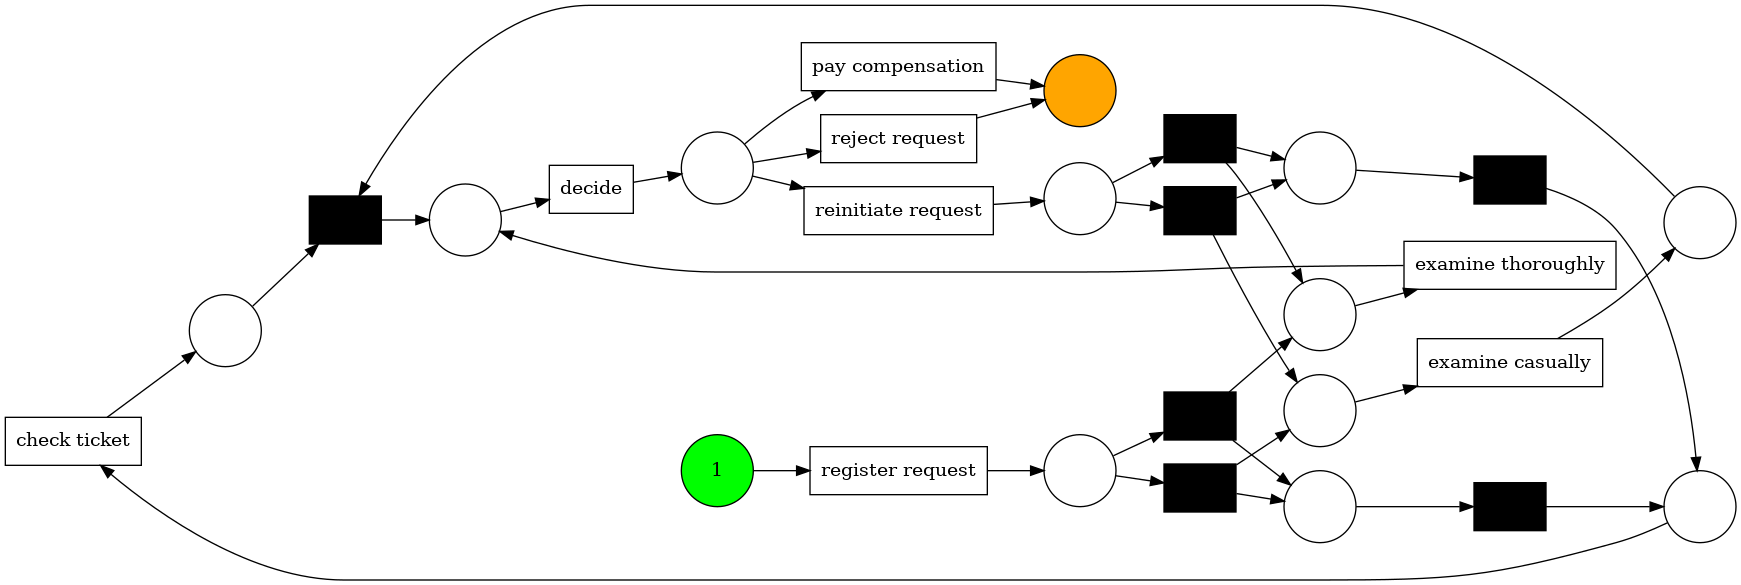

In [53]:
# GraphViz
gviz = pn_visualizer.apply(net, initial_marking, final_marking)

# View
pn_visualizer.view(gviz)

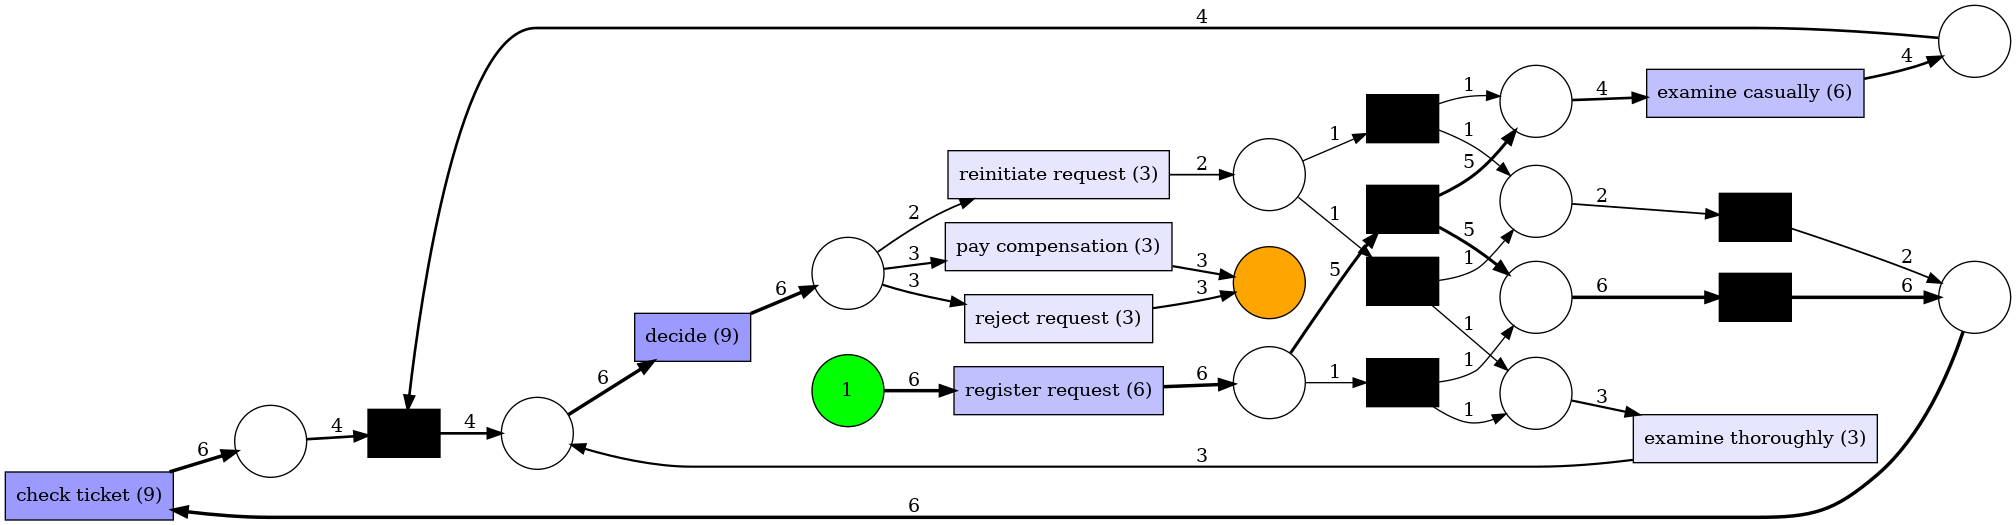

In [54]:
# GraphViz
gviz = pn_visualizer.apply(net, initial_marking, final_marking,
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)

# View
pn_visualizer.view(gviz)

## 5.4 Inductive Miner

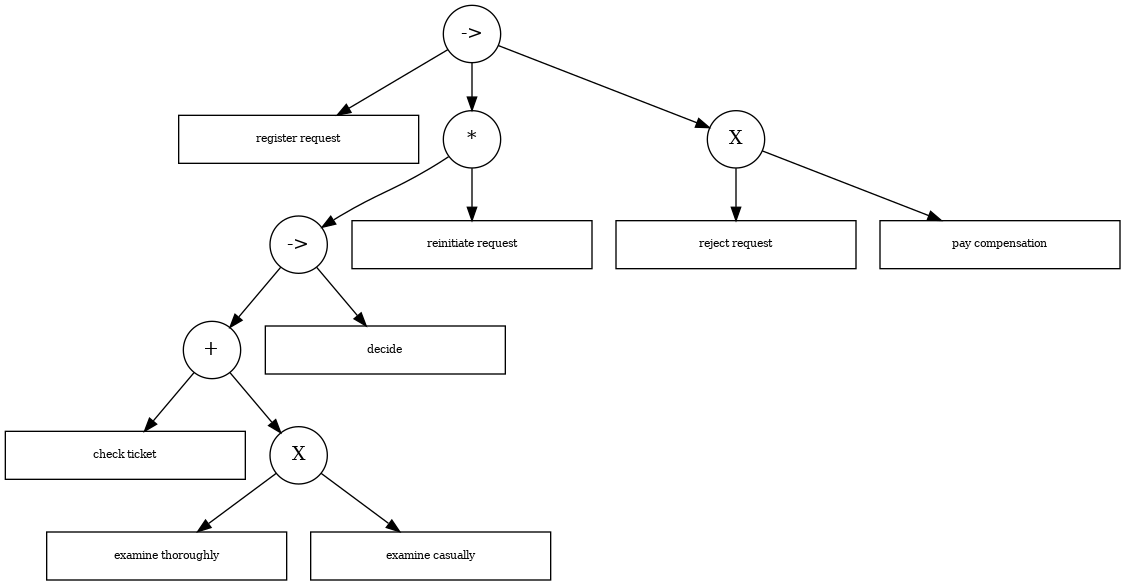

In [55]:
# Miner
tree = inductive_miner.apply_tree(log)

# GraphViz
gviz = pt_visualizer.apply(tree)

# View
pt_visualizer.view(gviz)

Convert the proces tree to a Petri net.

In [43]:
# Convert the process tree to a petri net
net, initial_marking, final_marking = pt_converter.apply(tree)

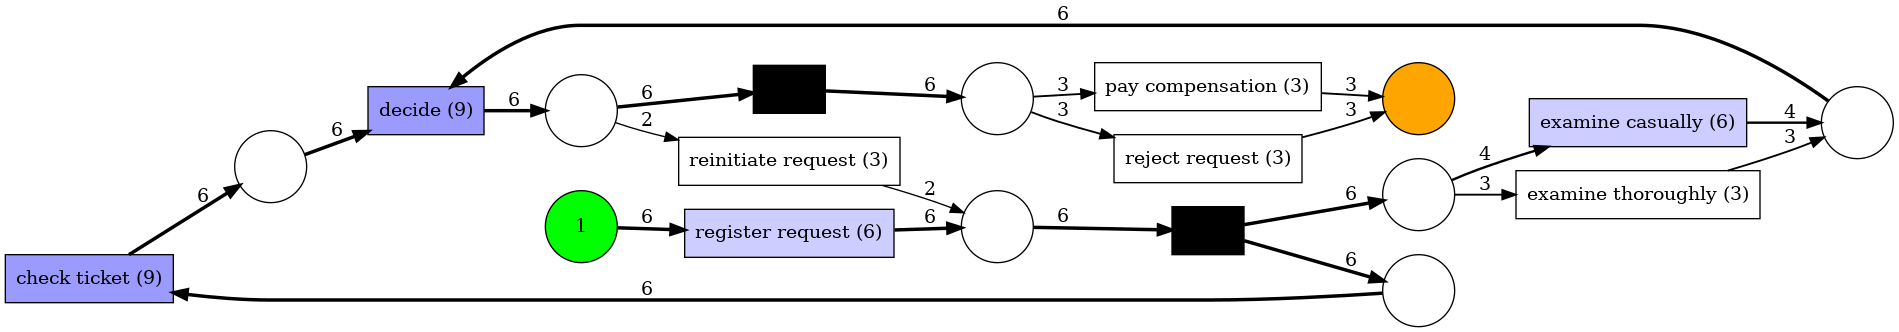

In [44]:
# Parameters
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: 'png'}

# GraphViz
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                           parameters=parameters, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)

# View
pn_visualizer.view(gviz)

Or use the inductive miner to generate a Petri net from scratch.

In [45]:
# Miner
net, initial_marking, final_marking = inductive_miner.apply(log)

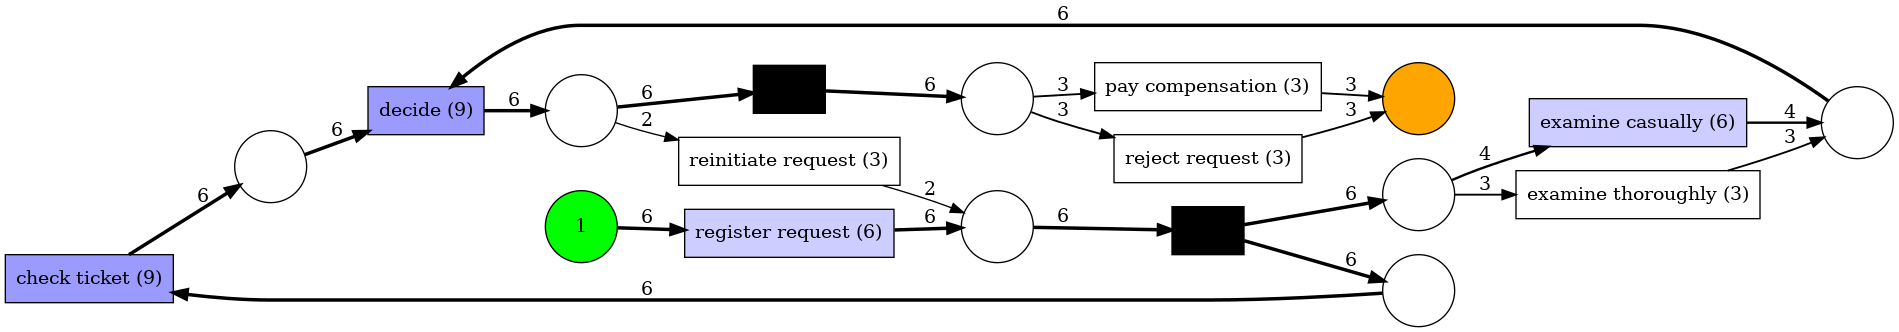

In [46]:
# Parameters
parameters = {pn_visualizer.Variants.FREQUENCY.value.Parameters.FORMAT: 'png'}

# GraphViz
gviz = pn_visualizer.apply(net, initial_marking, final_marking, 
                           parameters=parameters, 
                           variant=pn_visualizer.Variants.FREQUENCY, 
                           log=log)

# View
pn_visualizer.view(gviz)

**Resources:**
- PM4PY [documentation](https://pm4py.fit.fraunhofer.de/documentation)
- Towards Data Science story [Introduction to Process Mining](https://towardsdatascience.com/introduction-to-process-mining-5f4ce985b7e5)
- Process Mining for Python on [Youtube](https://www.youtube.com/channel/UCRcgOKrDsntrTI78RXXliuw/videos)

In [262]:
t = footprint_matrix(log_csv, 'case_id', 'activity', 'timestamp')
t

,register request,examine casually,check ticket,decide,reinitiate request,examine thoroughly,pay compensation,reject request
register request,0,3,2,0,0,1,0,0
examine casually,0,0,4,2,0,0,0,0
check ticket,0,2,0,6,0,1,0,0
decide,0,0,0,0,3,0,3,3
reinitiate request,0,1,1,0,0,1,0,0
examine thoroughly,0,0,2,1,0,0,0,0
pay compensation,0,0,0,0,0,0,0,0
reject request,0,0,0,0,0,0,0,0
